In [123]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib ipympl

# one hour flight, 5 minute taxi, 10 minute climb, 25 minute cruise, 5 minute descend, 5 minute traffic pattern, landing, and taxi
# sensor update rate: 10 hz

initial_tank_l = 25
tank_full_l = 32

flight = [
  {'name': 'startup', 't': 1*60, 'lps': 0/3600},
  {'name': 'taxi_s', 't': 5*60, 'lps': 6/3600},
  {'name': 'to_climb_s', 't': 10*60, 'lps' : 20/3600},
  # {'name': 'cruise_s', 't': 35*60, 'lps': 12/3600},
  # {'name': 'descent_s', 't': 5*60, 'lps': 4/3600},
  # {'name': 'ldg_s', 't': 5*60, 'lps': 8/3600},
]

flight_secs = sum([phase['t'] for phase in flight])

f_real_data = 100 #hz

f_flow_sensor = 10 #hz
f_fuel_sensor = 10 #hz

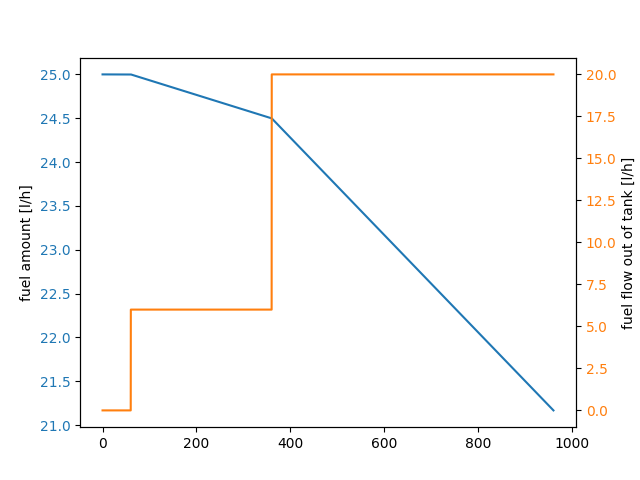

In [124]:
"""
Real Fuel Flow values taken from examplary flight, see above, sampling rate is high
"""
x_values_real_data = np.linspace(0, flight_secs*f_real_data, num=flight_secs*f_real_data)
x_values_real_data_s = np.linspace(0, flight_secs, num=flight_secs*f_real_data)

flow_y_values = np.concatenate([np.full(phase['t'] * f_real_data, phase['lps']) for phase in flight])

"""
True amount of fuel in the tank, when integrating the flow values
"""
state_y_values = initial_tank_l+scipy.integrate.cumulative_trapezoid(-flow_y_values, x_values_real_data_s, initial=0)

# plot this shit
fig, ax = plt.subplots(1)
ax.plot(x_values_real_data_s, state_y_values)
ax.set_ylabel('fuel amount [l/h]')
ax.tick_params(axis='y', labelcolor="tab:blue")

ax2 = ax.twinx()
ax2.plot(x_values_real_data_s, flow_y_values*3600, color="tab:orange")
ax2.set_ylabel('fuel flow out of tank [l/h]')
ax2.tick_params(axis='y', labelcolor="tab:orange")

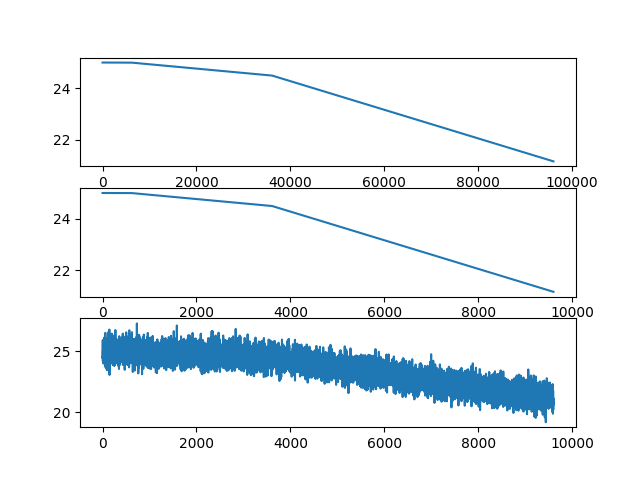

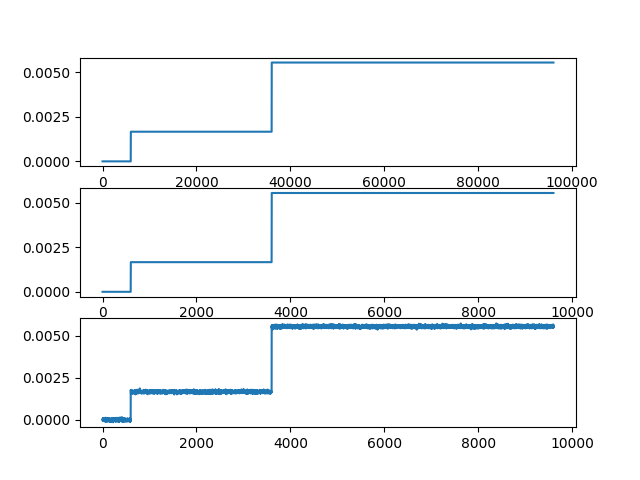

In [151]:

np.random.seed(1209386)


# distribution parameters for fuel flow sensor
std_dev_flow_sensor = .0025 * 16 * 4.54609 / 60 / 60
# distribution parameters for fuel state sensor, estimated at about 1 liter stddev, hopefully a good initial guess
std_dev_fuel_sensor = 0.6

# generate flow sensor values. the values array contains all samples the sensor would take over time when sampling with f_flow_sensor
flow_values_sensed = np.interp(np.linspace(0, flight_secs*f_real_data, num=int(np.ceil(flight_secs*f_flow_sensor))), x_values_real_data, flow_y_values, left=flow_y_values[0], right=flow_y_values[-1]) 
flow_values_noised = flow_values_sensed + np.random.normal(0, std_dev_flow_sensor, flow_values_sensed.shape)
# x values of these samples in seconds
flow_x_values = np.linspace(0, flight_secs, num=int(np.ceil(flight_secs*f_flow_sensor)))

# generate fuel state sensor values. the values array contains all samples the sensor would take over time when sampling with f_fuel_sensor
state_values_sensed = np.interp(np.linspace(0, flight_secs*f_real_data, num=int(np.ceil(flight_secs*f_fuel_sensor))), x_values_real_data, state_y_values, left=state_y_values[0], right=state_y_values[-1]) 
state_values_noised = state_values_sensed + np.random.normal(0, std_dev_fuel_sensor, state_values_sensed.shape)
# x values of these samples in seconds
state_x_values = np.linspace(0, flight_secs, num=int(np.ceil(flight_secs*f_fuel_sensor)))

# plot this shit
fig, axs = plt.subplots(3)
axs[0].plot(flow_y_values)
axs[1].plot(flow_values_sensed)
axs[2].plot(flow_values_noised)

fig2, axs2 = plt.subplots(3)
axs2[0].plot(state_y_values)
axs2[1].plot(state_values_sensed)
axs2[2].plot(state_values_noised)
plt.show()

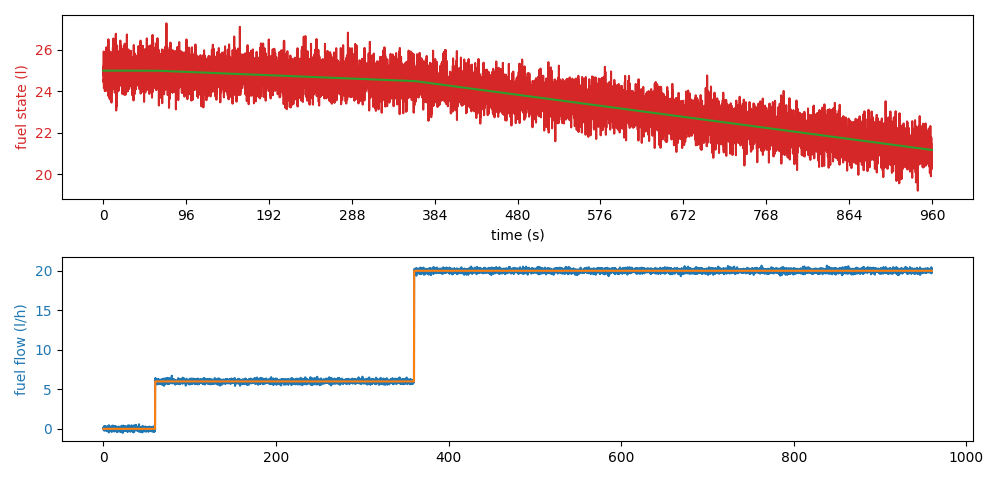

In [152]:
# plot actual values against measured (noised) values
fig, axs = plt.subplots(2)
fig.set_figwidth(10)

ax1 = axs[0]
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('fuel state (l)', color=color)
ax1.plot(state_x_values, state_values_noised, color=color)
ax1.set_xticks(np.linspace(0, flight_secs, 11), np.linspace(0, flight_secs, 11, dtype=int))
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
ax1.plot(x_values_real_data_s, state_y_values, color=color)


ax2 = axs[1]  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('fuel flow (l/h)', color=color)  # we already handled the x-label with ax1
ax2.plot(flow_x_values, flow_values_noised*3600, color=color)
ax2.tick_params(axis='y', labelcolor=color)


color = 'tab:orange'
ax2.plot(flow_x_values, flow_values_sensed*3600, color=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

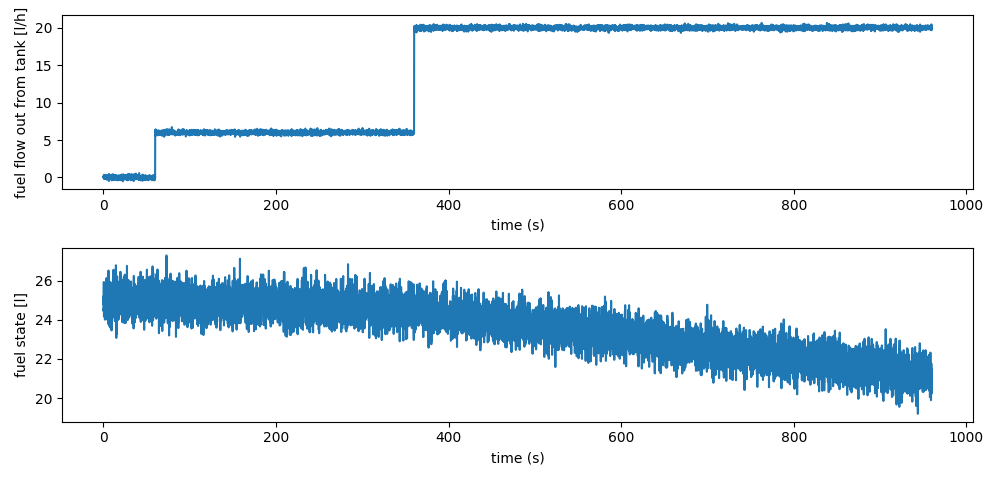

In [153]:
import scipy.interpolate

# transforming the noised values back into real world (like) sampling frequencies, so they are aligned for the kalman filter
flow_values_noised_f_real_data = scipy.interpolate.make_interp_spline(flow_x_values, flow_values_noised, k = 0)(x_values_real_data_s)
state_values_noised_f_real_data = scipy.interpolate.make_interp_spline(state_x_values, state_values_noised, k = 0)(x_values_real_data_s)

fig, axs = plt.subplots(2)
fig.set_figwidth(10)

ax1 = axs[0]
ax1.set_xlabel('time (s)')
ax1.set_ylabel('fuel flow out from tank [l/h]')
ax1.plot(x_values_real_data_s, flow_values_noised_f_real_data * 3600)
ax1.tick_params(axis='y')


ax2 = axs[1]

ax2.set_xlabel('time (s)')
ax2.set_ylabel('fuel state [l]')
ax2.plot(x_values_real_data_s, state_values_noised_f_real_data)
ax2.tick_params(axis='y')
fig.subplots_adjust(hspace=.5)
fig.tight_layout()

In [154]:
# combined measurements

z = np.concatenate((state_values_noised_f_real_data.reshape((-1,1,1)), flow_values_noised_f_real_data.reshape((-1,1,1))), axis=1)
z.shape

(96000, 2, 1)

In [ ]:
# Filter

# distribution parameter for process noise of fuel flow
mu_flow = 0
sigma_flow = .001

# tuning factor, white noise spectral density of changes in fuel flow
Phi_s = 1

# timestep seconds
dt = 1 / f_real_data 

# state transition x_t to x_t+1 (prediction according to model)
F = np.array([
  [1, -dt],
  [0, 1]
])

# initialization

alpha = 0.999

# calculated with continuous white noise model from https://drive.google.com/file/d/0By_SW19c1BfhSVFzNHc0SjduNzg/view?resourcekey=0-41olC9ht9xE3wQe2zHZ45A p.243ff, chapter 7.3.1
# Q = np.empty((len(x_values_real_data_s), 2, 2))

# Q[0] = np.array([
#   [0, 0],
#   [0, 0.5/60/60/f_real_data]
# ])
Q = np.array([
  [0.00000001,0],
  [0,0.00000000001]
])

# assumes that the measurement space and the state space are equal
H = np.identity(F.shape[0])

# taken from datasheets
# R = np.empty((len(x_values_real_data_s), 2, 2))
# R[0] = np.diag([np.pow(std_dev_fuel_sensor, 2), np.pow(std_dev_fuel_sensor, 2)])
R = np.diag([np.pow(std_dev_fuel_sensor, 2), np.pow(std_dev_flow_sensor, 2)])

# we need to start somewhere
x_posterior = np.empty((len(x_values_real_data_s), 2, 1)) 
x_posterior[0] = np.array([[state_values_noised_f_real_data[0]], [flow_values_noised_f_real_data[0]]])

P_posterior = np.empty((len(x_values_real_data_s), 2, 2))
P_posterior[0] = np.diag([np.pow(std_dev_fuel_sensor, 2), np.pow(std_dev_flow_sensor, 2)])

for k in range(1, len(x_values_real_data_s)):
  # predict
  x_prior = F @ x_posterior[k-1]
  # P_k_prior = F @ P_posterior[k-1] @ F.T + Q[k-1]
  P_k_prior = F @ P_posterior[k-1] @ F.T + Q

  # correct
  d_k = z[k] - H @ x_prior # innovation

  S_k = H @ P_k_prior @ H.T + R # innovation covariance
  K = P_k_prior @ H.T @ np.linalg.inv(S_k) # kalman gain
  x_posterior[k] = x_prior + K @ d_k # posterior state
  P_posterior[k] = (np.identity(x_prior.shape[0]) - K @ H) @ P_k_prior

  # update Process and Measurement cov matrices
  # Q[k] = alpha * Q[k-1] + (1 - alpha) * (K @ (d_k.reshape((2,1)) @ d_k.reshape((2,1)).T) @ K.T)



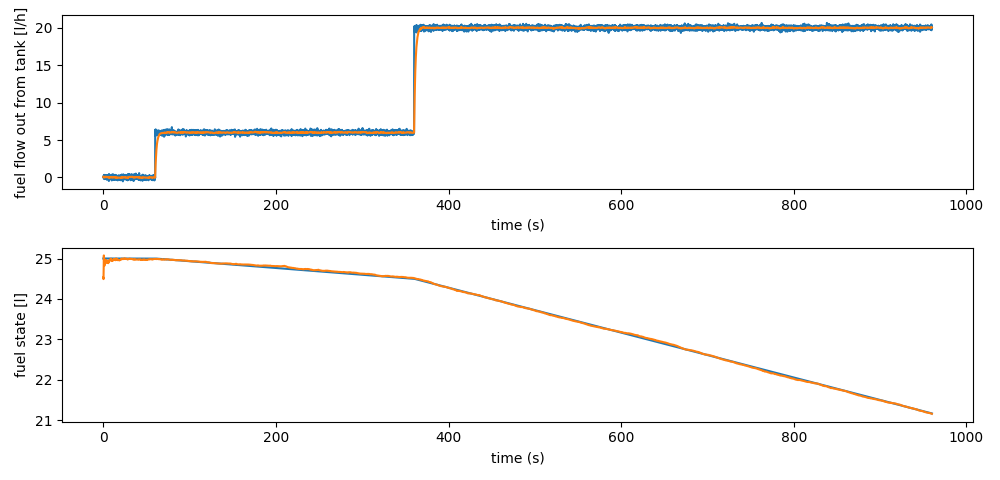

In [171]:
# x_posterior.T.shape
predicted_fuel, predicted_flow = np.split(x_posterior.reshape((-1,2)), 2, axis=1)


fig, axs = plt.subplots(2)
fig.set_figwidth(10)

ax1 = axs[0]
ax1.set_xlabel('time (s)')
ax1.set_ylabel('fuel flow out from tank [l/h]')
ax1.plot(x_values_real_data_s, flow_values_noised_f_real_data * 3600)
ax1.plot(x_values_real_data_s, predicted_flow * 3600)
ax1.tick_params(axis='y')


ax2 = axs[1]

ax2.set_xlabel('time (s)')
ax2.set_ylabel('fuel state [l]')
# ax2.plot(x_values_real_data_s, state_values_noised_f_real_data)
ax2.plot(x_values_real_data_s, state_y_values)
ax2.plot(x_values_real_data_s, predicted_fuel)
ax2.tick_params(axis='y')
fig.subplots_adjust(hspace=.5)
fig.tight_layout()
plt.show()